<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/cars_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем dataset из kaggle

In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c hse-cars-competition

 99% 1.81G/1.82G [00:18<00:00, 192MB/s]
100% 1.82G/1.82G [00:18<00:00, 108MB/s]


In [ ]:
!unzip hse-cars-competition.zip

In [4]:
import pandas as pd
import numpy as np

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [41]:
train_ann = pd.read_csv('./annotation/train_ann.csv')

In [45]:
len(train_ann)

8132

In [3]:
train_ann.sample(3)

,imname,class
1647,train/fd664f8ecc2b0618b9b9b53bdd616949.jpg,119
2056,train/50b2291d17b90b46ee8754649158f65a.jpg,172
1605,train/d99a77e89b8f08511856148cb5f55a83.jpg,66


In [ ]:
plot_data = train_ann.groupby(['class'])['class'].count().to_frame('count')

In [ ]:
plot_data['count'].min()

24

In [ ]:
plot_data['count'].max()

68

In [ ]:
plot_data['count'].mean()

41.48979591836735

<ipython-input-26-89dd7cb67e5e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')


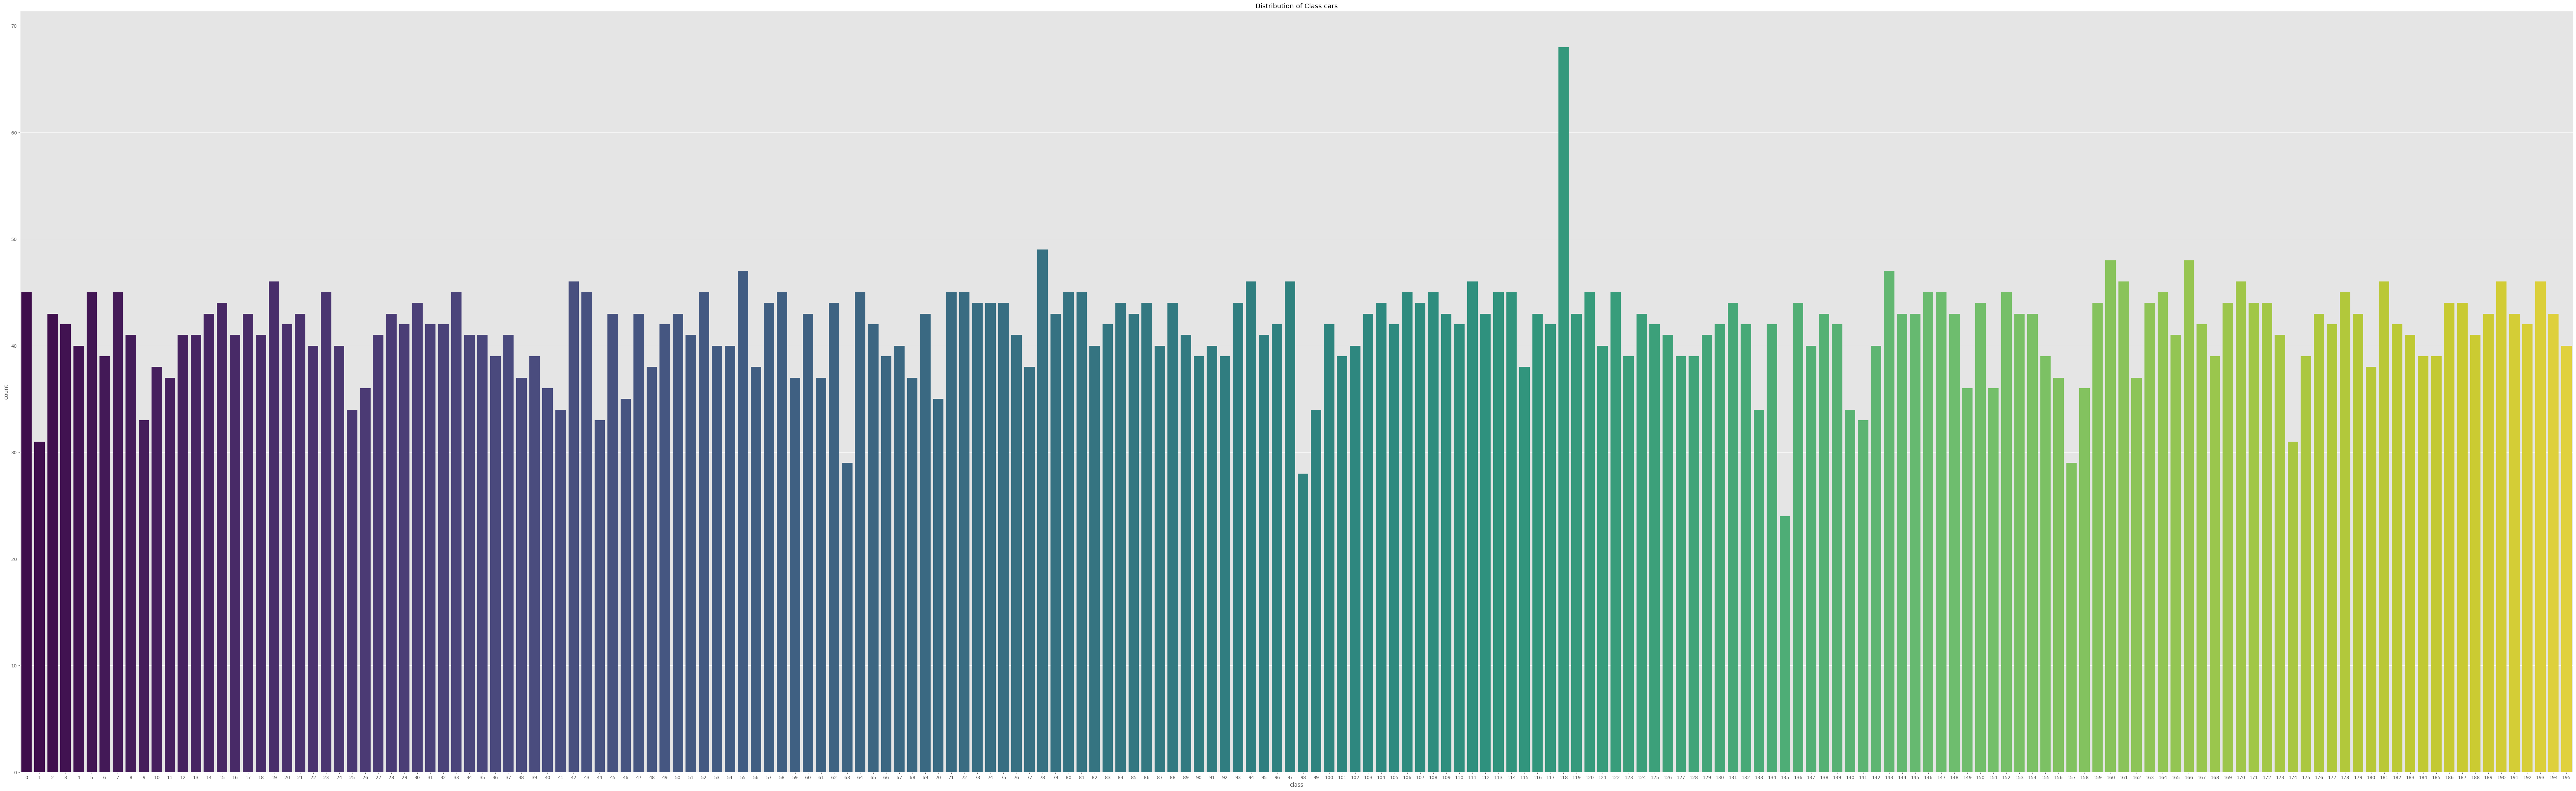

In [ ]:
plt.figure(figsize=(100, 30))

ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')

plt.xlabel('class')
plt.ylabel('count')
plt.title('Distribution of Class cars')

plt.show()

Наблюдаем что классы несбалансированы, особенно класс 118

Идея попробовать сбалансировать датасет по минимальной шкале и обучить модель


In [10]:
def balanced_annotation(ann, max_count):
  class_dict = {}
  b_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    if class_dict[target] <= max_count:
      new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])
      b_ann = pd.concat([b_ann.loc[:], new_row]).reset_index(drop=True)

  return b_ann


In [11]:
train_ann_b = balanced_annotation(train_ann, 10)

In [46]:
train_ann_b = train_ann

In [47]:
len(train_ann_b)

8132

In [13]:
def train_test_split_annotation(ann, max_count, percent):
  class_dict = {}
  train_ann = pd.DataFrame()
  test_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])

    if class_dict[target] / max_count < percent:
      train_ann = pd.concat([train_ann.loc[:], new_row]).reset_index(drop=True)
    else:
      test_ann = pd.concat([test_ann.loc[:], new_row]).reset_index(drop=True)


  return train_ann, test_ann


In [14]:
train_ann_b, val_ann_b = train_test_split_annotation(train_ann_b, 10, 0.8)

In [15]:
len(train_ann_b)

1372

In [16]:
len(val_ann_b)

588

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from PIL import Image
from tqdm.auto import tqdm

In [6]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda', index=0)

In [89]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [9]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, root_dir, imlist, transform=None):
        """
        Arguments:
            imlist(pandas DataFrame): DataFrame with columns file_name, class
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.imlist = imlist
        self.transform = transform

    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):
        impath, target = self.imlist.loc[idx]
        full_imname = os.path.join(self.root_dir, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)
            pass

        img = Image.open(full_imname).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [10]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

In [48]:
train_set = CarsDataset('./images',
                        train_ann_b,
                        transform=get_train_transform(IMAGE_SIZE))

val_set = CarsDataset('./images',
                      train_ann_b,
                      transform=get_valid_transform(IMAGE_SIZE))

In [49]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=True)

In [37]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

def save_model(epoch, model, optimizer, criterion, acc):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"model_epoch_{epoch}_acc{acc}.pth")

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [27]:
def train(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [28]:
def validate(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [50]:
# Learning_parameters.
lr = 0.001
epochs = 50

In [18]:
def build_model(pretrained=True, fine_tune=True, num_classes=196):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')

    model = models.efficientnet_v2_s(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [51]:
import torch.nn.functional as F


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [51]:
# Load the model.
model = build_model(pretrained=True, fine_tune=True).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Loss function.
criterion = LabelSmoothingCrossEntropy()

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Fine-tuning all layers...
20,428,564 total parameters.
20,428,564 training parameters.


[INFO]: Epoch 1 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 5.082, training acc: 1.832
Validation loss: 4.592, validation acc: 4.661
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 4.390, training acc: 7.784
Validation loss: 3.756, validation acc: 17.597
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 3.729, training acc: 19.491
Validation loss: 3.060, validation acc: 33.424
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 3.152, training acc: 32.895
Validation loss: 2.503, validation acc: 51.660
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.699, training acc: 46.569
Validation loss: 1.976, validation acc: 69.196
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.415, training acc: 55.042
Validation loss: 1.825, validation acc: 73.942
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.178, training acc: 62.826
Validation loss: 1.652, validation acc: 80.312
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.004, training acc: 67.843
Validation loss: 1.473, validation acc: 86.289
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.895, training acc: 71.065
Validation loss: 1.383, validation acc: 89.683
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.784, training acc: 75.148
Validation loss: 1.348, validation acc: 90.248
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.704, training acc: 77.951
Validation loss: 1.279, validation acc: 92.806
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.626, training acc: 80.263
Validation loss: 1.254, validation acc: 93.212
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.562, training acc: 82.477
Validation loss: 1.218, validation acc: 94.282
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.519, training acc: 84.333
Validation loss: 1.182, validation acc: 95.241
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.468, training acc: 85.785
Validation loss: 1.160, validation acc: 95.610
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.442, training acc: 86.424
Validation loss: 1.144, validation acc: 96.520
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.424, training acc: 86.879
Validation loss: 1.129, validation acc: 96.483
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.388, training acc: 88.010
Validation loss: 1.112, validation acc: 96.877
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.348, training acc: 88.920
Validation loss: 1.104, validation acc: 97.000
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.327, training acc: 89.560
Validation loss: 1.074, validation acc: 97.393
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.317, training acc: 90.039
Validation loss: 1.075, validation acc: 97.627
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.289, training acc: 91.072
Validation loss: 1.065, validation acc: 98.131
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.259, training acc: 92.105
Validation loss: 1.062, validation acc: 97.750
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.270, training acc: 91.761
Validation loss: 1.058, validation acc: 97.946
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.227, training acc: 92.769
Validation loss: 1.044, validation acc: 98.438
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.228, training acc: 92.782
Validation loss: 1.035, validation acc: 98.352
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.233, training acc: 92.327
Validation loss: 1.042, validation acc: 98.426
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.224, training acc: 92.757
Validation loss: 1.027, validation acc: 98.500
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.209, training acc: 93.151
Validation loss: 1.011, validation acc: 98.475
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.184, training acc: 94.036
Validation loss: 1.027, validation acc: 98.537
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.183, training acc: 94.626
Validation loss: 1.013, validation acc: 98.660
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.174, training acc: 94.393
Validation loss: 1.028, validation acc: 98.537
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.168, training acc: 94.786
Validation loss: 1.013, validation acc: 98.721
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.182, training acc: 94.024
Validation loss: 1.000, validation acc: 98.942
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.162, training acc: 94.663
Validation loss: 0.992, validation acc: 99.029
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.131, training acc: 95.352
Validation loss: 0.990, validation acc: 99.139
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.149, training acc: 94.934
Validation loss: 0.985, validation acc: 99.225
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.127, training acc: 95.856
Validation loss: 0.998, validation acc: 98.697
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.120, training acc: 95.684
Validation loss: 1.012, validation acc: 98.057
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.128, training acc: 95.376
Validation loss: 0.982, validation acc: 99.016
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.123, training acc: 95.708
Validation loss: 0.974, validation acc: 99.410
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.113, training acc: 95.758
Validation loss: 0.988, validation acc: 98.930
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.105, training acc: 96.114
Validation loss: 0.974, validation acc: 99.188
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.121, training acc: 95.647
Validation loss: 0.976, validation acc: 99.152
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.116, training acc: 95.536
Validation loss: 0.969, validation acc: 99.373
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.103, training acc: 96.286
Validation loss: 0.974, validation acc: 99.410
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.094, training acc: 96.348
Validation loss: 0.985, validation acc: 98.918
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.092, training acc: 96.212
Validation loss: 0.967, validation acc: 99.311
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.069, training acc: 97.221
Validation loss: 0.955, validation acc: 99.373
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.082, training acc: 96.778
Validation loss: 0.961, validation acc: 99.533
--------------------------------------------------
TRAINING COMPLETE


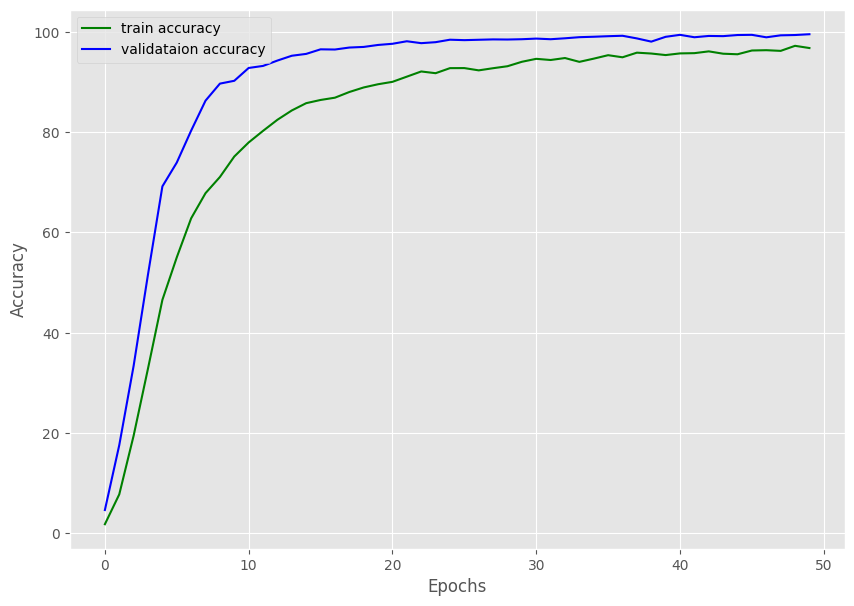

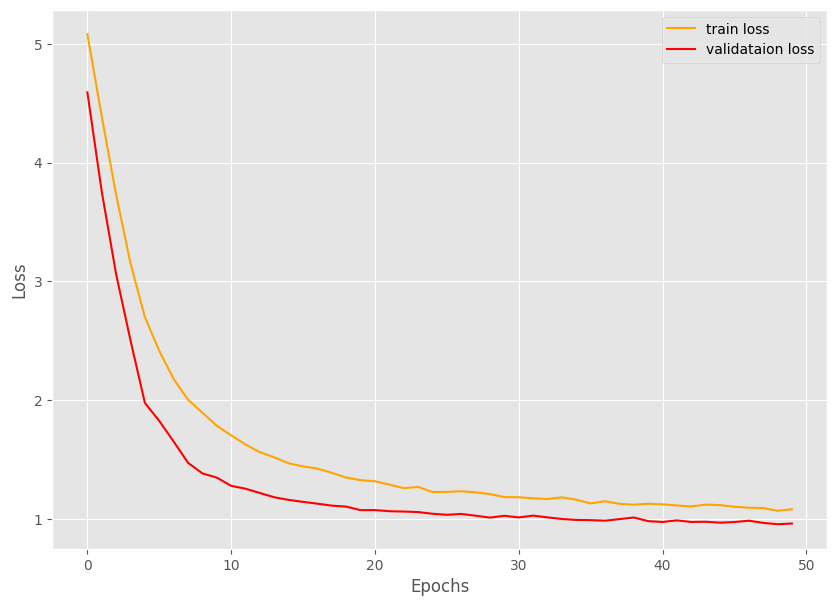

In [52]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if len(valid_acc) == 1 or valid_epoch_acc >= max(valid_acc[:-1]):
        save_model(epoch, model, optimizer, criterion, valid_epoch_acc)


# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)

print('TRAINING COMPLETE')

In [52]:
checkpoint = torch.load('./model_epoch_49_acc99.53271028037383.pth', map_location=torch.device('cpu'))

model = build_model(pretrained=True, fine_tune=True).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Fine-tuning all layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
test_dir = './images/test'
test_images = sorted(os.listdir('./images/test'))

predicts = []

for i in tqdm(range(len(test_images))):
    full_imname = os.path.join(test_dir, test_images[i])
    image = Image.open(full_imname)

    tranforms = get_valid_transform(IMAGE_SIZE)
    try:
      input_tensor = tranforms(image)
    except:
      image = image.convert('RGB')
      input_tensor = tranforms(image)

    input_batch = input_tensor.unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicts.append(predicted_class.item())

  0%|          | 0/8033 [00:00<?, ?it/s]

In [78]:
full_imname = os.path.join('./images/train', 'fe251470bc3aca6f6f772bd10b31547b.jpg')
image = Image.open(full_imname)

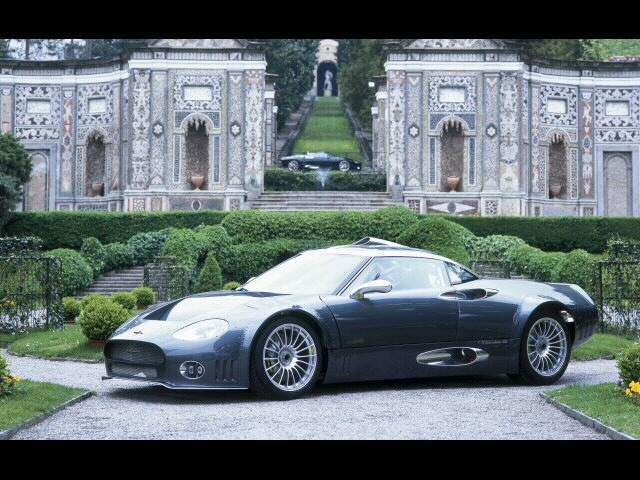

In [79]:
image

In [76]:
full_imname = os.path.join('./images/test', '001dfdc0c6f99c13e434a83ec2d272e6.jpg')
image = Image.open(full_imname)

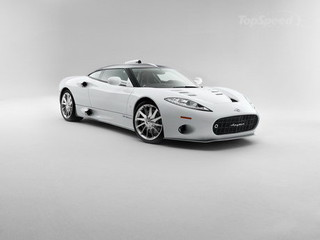

In [77]:
image

In [59]:
test_images = ['test/' + imname for imname in test_images]

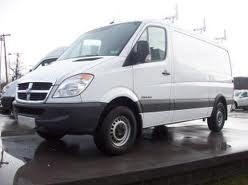

In [16]:
image

In [75]:
csv_name = 'model_49_epoch.csv'
df = pd.DataFrame({'new_name': test_images, 'class': predicts})

with open(csv_name, 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file,
            index=False,
            header=['new_name', 'class'],
            columns=['new_name', 'class'])